In [1]:
import numpy as np
import glob
import os
%pylab inline --no-import-all
# plt.rc('font', family='serif', serif='Times', size=15)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('figure', titlesize=25)
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['axes.linewidth'] = 2.
from astropy.io import fits

import logging as log
from crispy.tools.initLogger import getLogger
log = getLogger('main')
from crispy.tools.image import Image
os.chdir('/Users/mrizzo/IFS/crispy/crispy/PISCES/')
# os.chdir('/Users/mrizzo/IFS/crispy/crispy/WFIRST_tight/')
from params import Params
import scipy as sp
from astropy.io import fits

par = Params()
par.hdr
cmap = 'inferno'  # 'gray_r'

Populating the interactive namespace from numpy and matplotlib


# Using photutils package to fit PISCES PSFlets

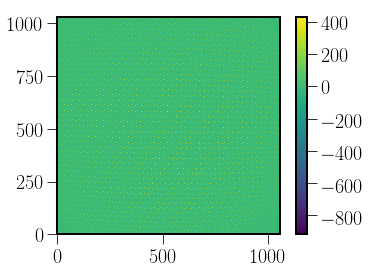

In [2]:
data = fits.getdata(par.wavecalDir+'det665.0.fits')
# data = fits.getdata(par.wavecalDir+'det_770.fits')


plt.imshow(data)
plt.colorbar()

In [3]:
from photutils import find_peaks
peaks_tbl = find_peaks(data, threshold=100.)
peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output
print(peaks_tbl)
from astropy.table import Table
stars_tbl = Table()
stars_tbl['x'] = peaks_tbl['x_peak']
stars_tbl['y'] = peaks_tbl['y_peak']
from astropy.stats import sigma_clipped_stats
mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.,
                                                    iters=None)
data -= median_val
from astropy.nddata import NDData
nddata = NDData(data=data)
from photutils.psf import extract_stars
stars = extract_stars(nddata, stars_tbl, size=12)


x_peak y_peak peak_value
------ ------ ----------
   139      0  111.66666
   171      0  142.66667
   204      1        144
   236      2  156.33333
   268      2        179
   794      2        162
   825      2  138.66667
   300      3  133.66667
   332      3  156.66667
   363      3  185.33333
   ...    ...        ...
   741   1028        154
   772   1029  146.33333
   802   1029  118.66666
   832   1029  133.66667
   386   1031  103.66666
   417   1031  119.66666
   448   1031  118.66666
   832   1031  119.66666
   862   1031  135.33333
   892   1031        149
   923   1031        142
Length = 5839 rows


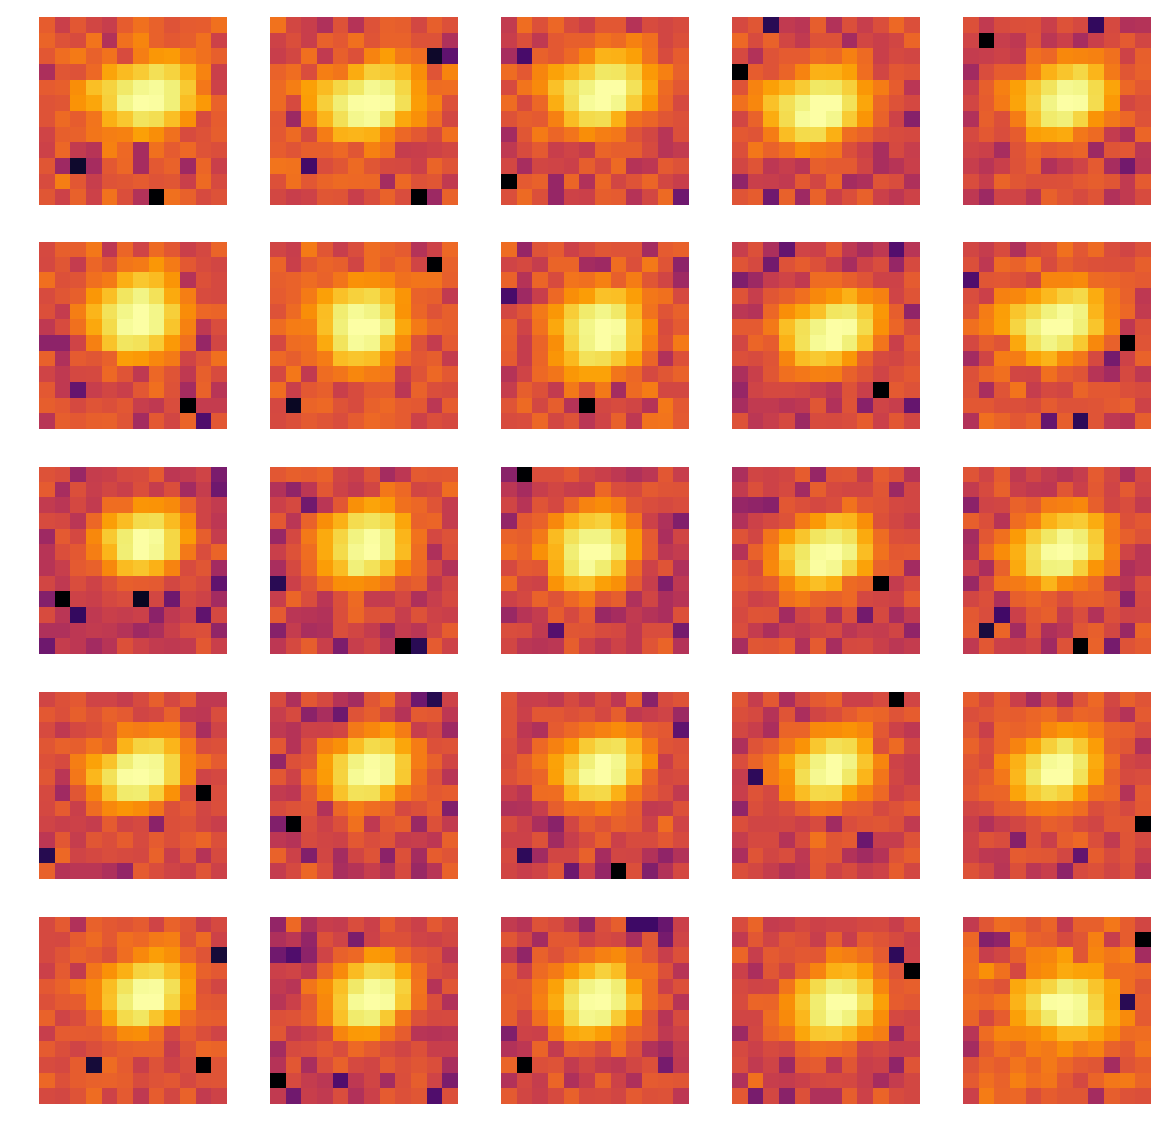

In [4]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
nrows = 5
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20),
                       squeeze=True)
ax = ax.ravel()
for i in range(nrows*ncols):
    norm = simple_norm(stars[i], 'log', percent=99.)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap=cmap)
    ax[i].axis('off')

In [4]:
from photutils import EPSFBuilder
epsf_builder = EPSFBuilder(oversampling=4, maxiters=3,
                           progress_bar=True)
epsf, fitted_stars = epsf_builder(stars)


ImportError: cannot import name EPSFBuilder

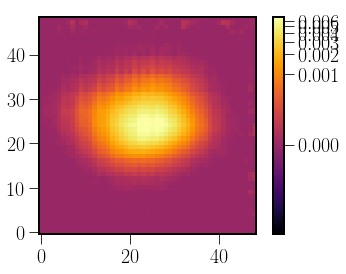

In [35]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
norm = simple_norm(epsf.data, 'log', percent=99.)
epsf.data[epsf.data<0.0]=0.0
plt.imshow(epsf.data, norm=norm, origin='lower', cmap=cmap)
plt.colorbar()

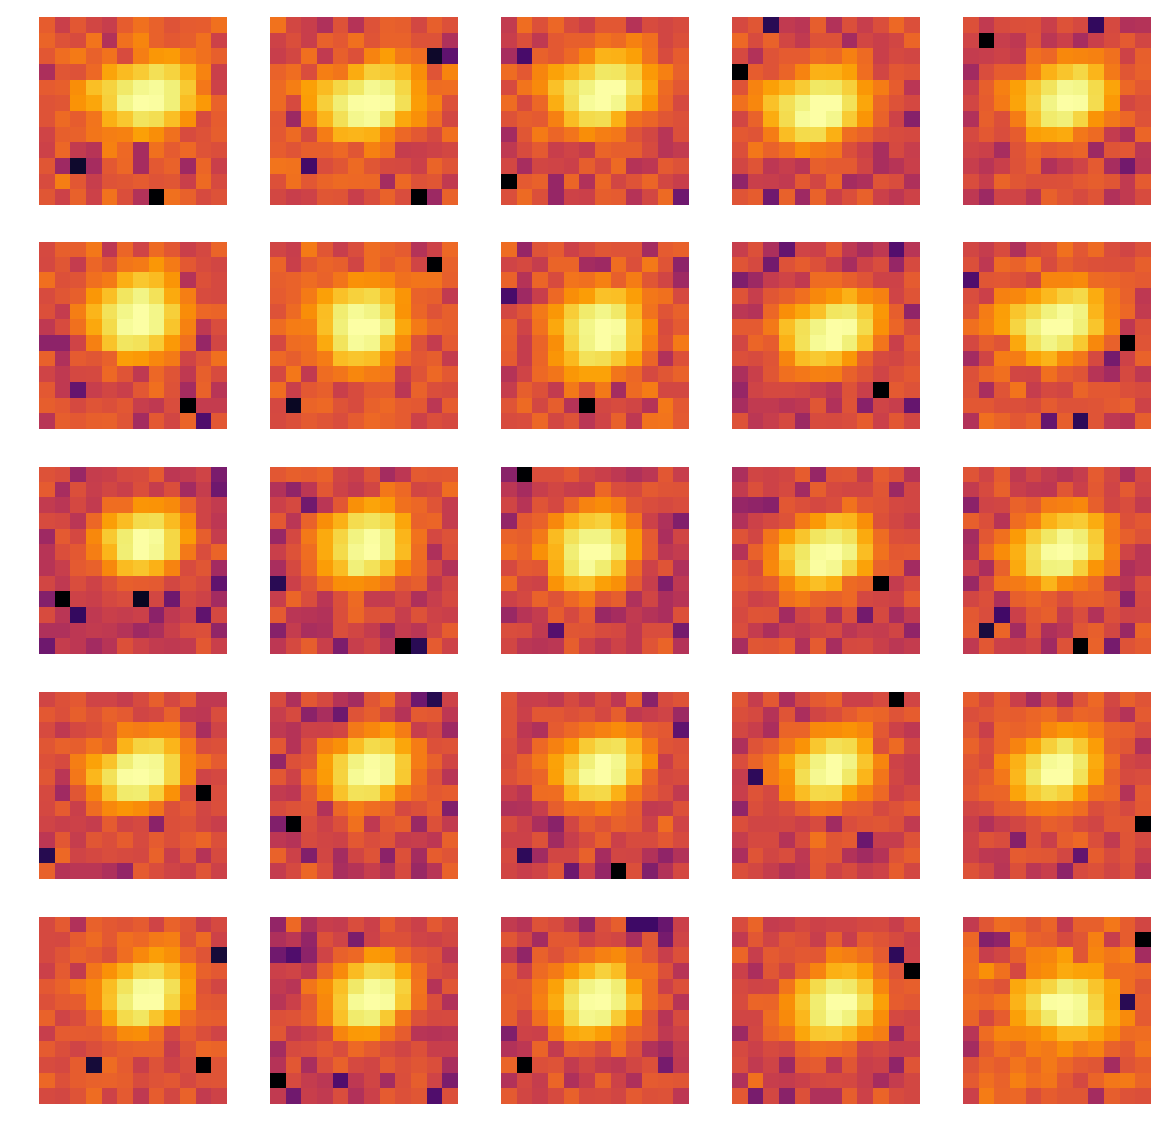

In [8]:
nrows = 5
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20),
                       squeeze=True)
ax = ax.ravel()
for i in range(nrows*ncols):
    norm = simple_norm(fitted_stars[i], 'log', percent=99.)
    ax[i].imshow(fitted_stars[i], norm=norm, origin='lower', cmap=cmap)
    ax[i].axis('off')

ImportError: cannot import name 'create_prf'

# Try to extract PSFlets

In [49]:
from photutils.psf import IterativelySubtractedPSFPhotometry,BasicPSFPhotometry
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from photutils.detection import IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from astropy.stats import gaussian_sigma_to_fwhm

sigma_psf = 1.5
bkgrms = MADStdBackgroundRMS()
std = bkgrms(data)
print (std)
iraffind = IRAFStarFinder(threshold=3.5*std,
                          fwhm=sigma_psf*gaussian_sigma_to_fwhm,
                          minsep_fwhm=0.01, roundhi=5.0, roundlo=-5.0,
                          sharplo=0.0, sharphi=2.0)
daogroup = DAOGroup(1.0*sigma_psf*gaussian_sigma_to_fwhm)
mmm_bkg = MMMBackground()
fitter = LevMarLSQFitter()
psf_model = IntegratedGaussianPRF(sigma=sigma_psf)
photometry = IterativelySubtractedPSFPhotometry(finder=iraffind,
                                                group_maker=daogroup,
                                                bkg_estimator=mmm_bkg,
                                                psf_model=epsf,
                                                fitter=LevMarLSQFitter(),
                                                fitshape=(9,9))

# photometry = BasicPSFPhotometry(group_maker=daogroup,
#                                 bkg_estimator=mmm_bkg,
#                                 psf_model=epsf,
#                                 fitter=LevMarLSQFitter(),
#                                 fitshape=(11,11))

# pos = Table(names=['x_0', 'y_0'], data=[stars_tbl['x'],
#                                         stars_tbl['y']])
# result_tab = photometry(image=data, init_guesses=pos)
# residual_image = photometry.get_residual_image()
# print(photometry)

result_tab = photometry(data)
residual_image = photometry.get_residual_image()

4.447806655516806


TypeError: '<' not supported between instances of 'NoneType' and 'int'

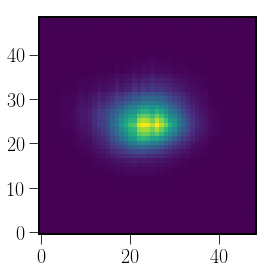

In [39]:
plt.imshow(epsf.data)

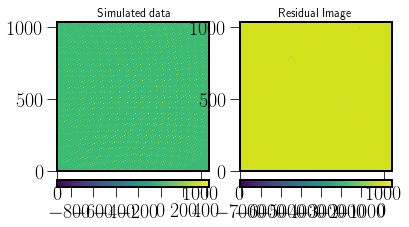

In [20]:
plt.subplot(1, 2, 1)
plt.imshow(data, cmap='viridis', aspect=1, interpolation='nearest', origin='lower')

plt.title('Original data')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
plt.subplot(1 ,2, 2)
plt.imshow(residual_image, cmap='viridis', aspect=1,
           interpolation='nearest', origin='lower')
plt.title('Residual Image')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

In [29]:
fits.writeto('/Users/mrizzo/Downloads/resid.fits',residual_image,overwrite=True)
fits.writeto('/Users/mrizzo/Downloads/orig_pisces.fits',data,overwrite=True)

# Repeat for WFIRST PSFlets

In [2]:
# data = fits.getdata('/Users/mrizzo/IFS/crispy/crispy/ReferenceFiles/wavecalR50_770_tight/det_770.fits')
data = fits.getdata('/Users/mrizzo/IFS/crispy/crispy/ReferenceFiles/Calibra_170425/det665.0.fits')
# data = data[200:400,200:400]

nsubarr = 4
npix=13
upsample=3
subim = data[:data.shape[0] // nsubarr,:data.shape[1] // nsubarr]
# just to get the shape right
test = get_hires(subim,upsample,npix)
hires_arr = np.zeros((nsubarr, nsubarr, test.shape[0], test.shape[1]))


for yreg in range(nsubarr):
    i1 = yreg * data.shape[0] // nsubarr
    i2 = i1 + data.shape[0] // nsubarr
    i1 = max(i1, npix)
    i2 = min(i2, data.shape[0] - npix)
    for xreg in range(nsubarr):
        j1 = xreg * data.shape[1] // nsubarr
        j2 = j1 + data.shape[1] // nsubarr
        j1 = max(j1, npix)
        j2 = min(j2, data.shape[1] - npix)
        subim = data[i1:i2,j1:j2]
        hires_arr[yreg,xreg] = get_hires(subim,upsample,npix)


plt.imshow(data)
plt.colorbar()

NameError: name 'get_hires' is not defined

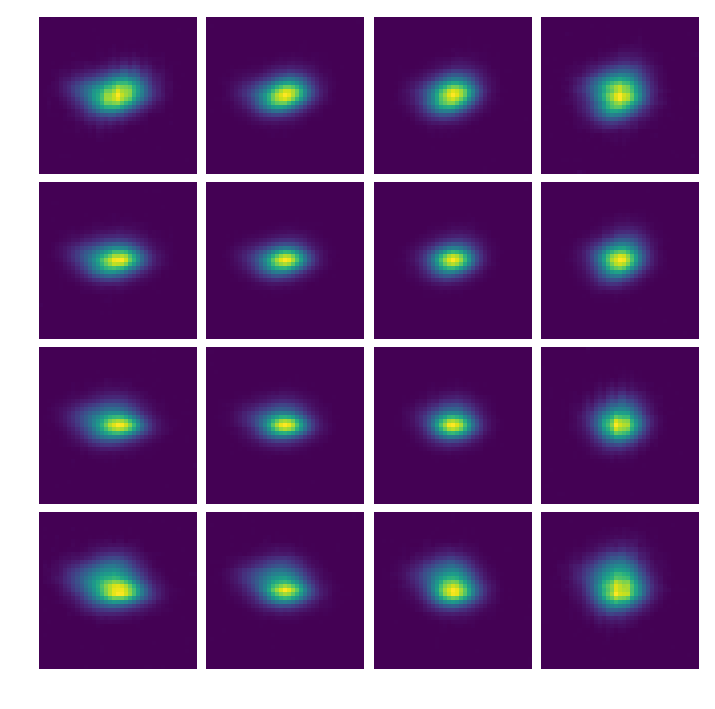

In [91]:
fig, axarr = plt.subplots(nsubarr,nsubarr,figsize=(12,12))
for i in range(hires_arr.shape[0]):
    for j in range(hires_arr.shape[1]):
        axarr[i,j].imshow(hires_arr[i,j],vmin=0.0)
        axarr[i,j].axis('off')
plt.subplots_adjust(wspace=0.0,hspace=0.05)


In [3]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from photutils import EPSFBuilder
from astropy.nddata import NDData
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from photutils import find_peaks
from photutils.psf import extract_stars
def get_hires(img,upsample,npix=13):
    data = img.copy()
    peaks_tbl = find_peaks(data, threshold=100.)
    peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output
    stars_tbl = Table()
    stars_tbl['x'] = peaks_tbl['x_peak']
    stars_tbl['y'] = peaks_tbl['y_peak']
    mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.,
                                                        iters=None)
    data -= median_val
    nddata = NDData(data=data)
    stars = extract_stars(nddata, stars_tbl, size=npix)
    epsf_builder = EPSFBuilder(oversampling=upsample, maxiters=3,
                               progress_bar=False)
    epsf, fitted_stars = epsf_builder(stars)
    return epsf.data
#     nrows = 5
#     ncols = 5
#     fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20),
#                            squeeze=True)
#     ax = ax.ravel()
#     for i in range(nrows*ncols):
#         norm = simple_norm(stars[i], 'linear',percent=99.)
#         ax[i].imshow(stars[i], norm=norm, origin='lower', cmap=cmap)
#         ax[i].axis('off')

ImportError: cannot import name EPSFBuilder

x_peak y_peak peak_value
------ ------ ----------
    91      7        104
   115     19        113
   175     19        118
   157     25        106
   187     25        104
    79     31        109
   139     31        101
   169     31        104
   181     37        109
   103     43        105
   ...    ...        ...
   199    151        102
   121    157        104
   181    157        108
   133    163        110
   163    163        107
    85    169        112
   175    169        102
   187    175        108
   169    181        107
    91    187        109
   151    187        107
Length = 64 rows


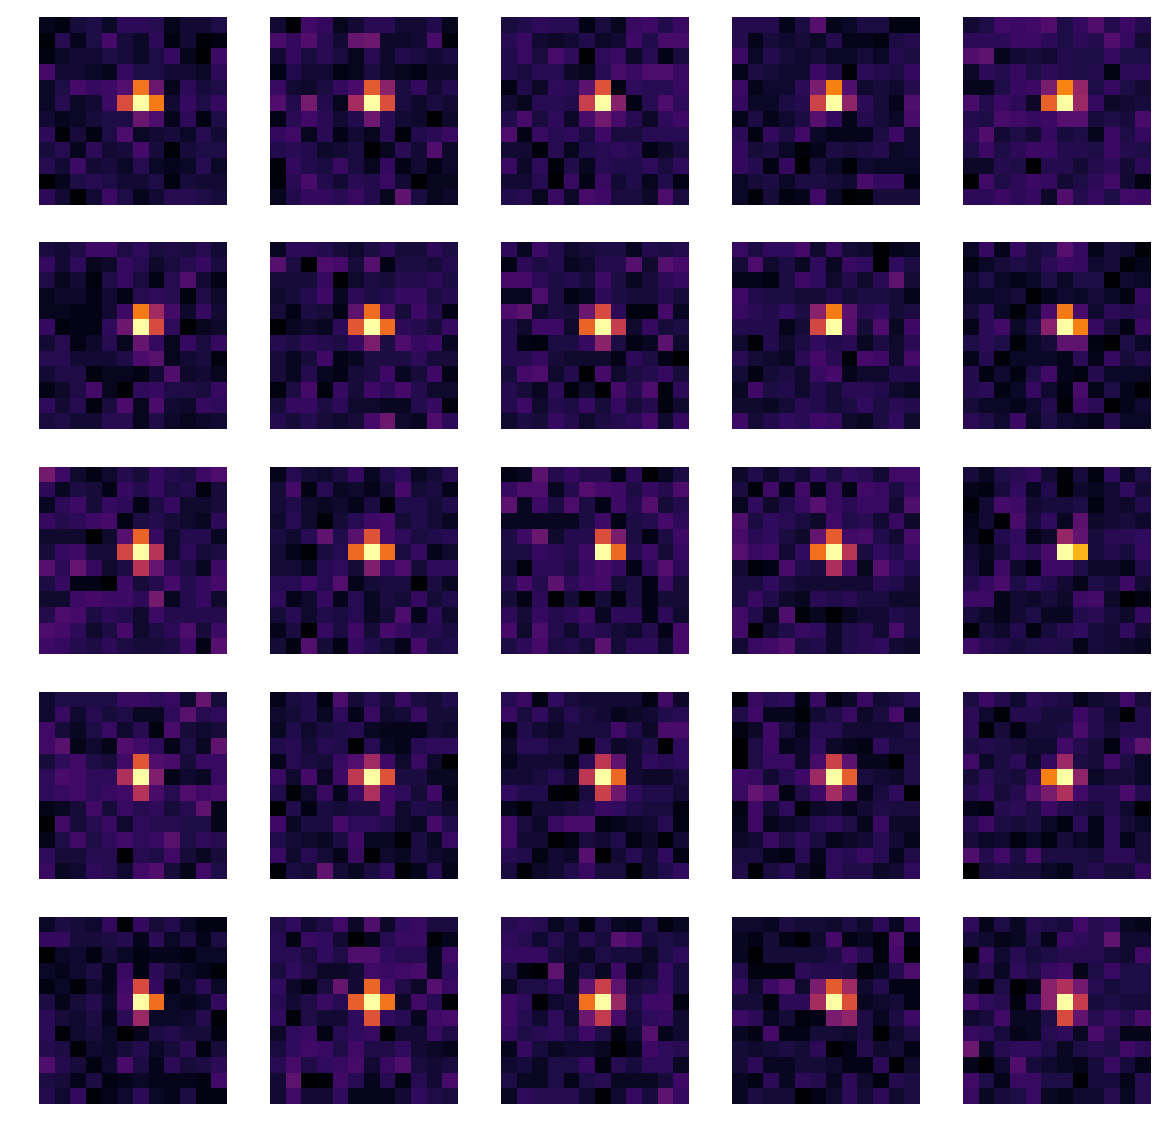

In [68]:
from photutils import find_peaks
peaks_tbl = find_peaks(data, threshold=100.)
peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output
print(peaks_tbl)
from astropy.table import Table
stars_tbl = Table()
stars_tbl['x'] = peaks_tbl['x_peak']
stars_tbl['y'] = peaks_tbl['y_peak']
from astropy.stats import sigma_clipped_stats
mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.,
                                                    iters=None)
data -= median_val
from astropy.nddata import NDData
nddata = NDData(data=data)
from photutils.psf import extract_stars
stars = extract_stars(nddata, stars_tbl, size=12)
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
nrows = 5
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20),
                       squeeze=True)
ax = ax.ravel()
for i in range(nrows*ncols):
    norm = simple_norm(stars[i], 'linear',percent=99.)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap=cmap)
    ax[i].axis('off')

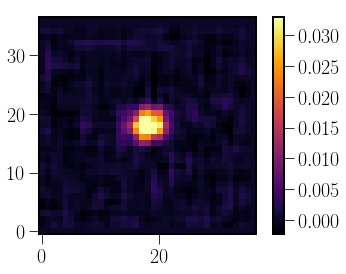

In [69]:
from photutils import EPSFBuilder
epsf_builder = EPSFBuilder(oversampling=3, maxiters=3,
                           progress_bar=True)
epsf, fitted_stars = epsf_builder(stars)
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
norm = simple_norm(epsf.data, 'linear', percent=99.)
plt.imshow(epsf.data, norm=norm, origin='lower', cmap=cmap)
plt.colorbar()